# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Цель проекта - построить модель, которая по фотографии определит приблизительный возраст человека.
В нашем распоряжении набор фотографий людей с указанием возраста.

Для реализации поставленной цели будут проделаны следующие шаги: проведен исследовательский анализ набора фотографий,
подготовлены данные к обучению, обучена нейронная сеть и рассчитано её качество.

## Исследовательский анализ данных

In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
data = pd.read_csv('/datasets/faces/labels.csv')

In [ ]:
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [ ]:
data.shape

(7591, 2)

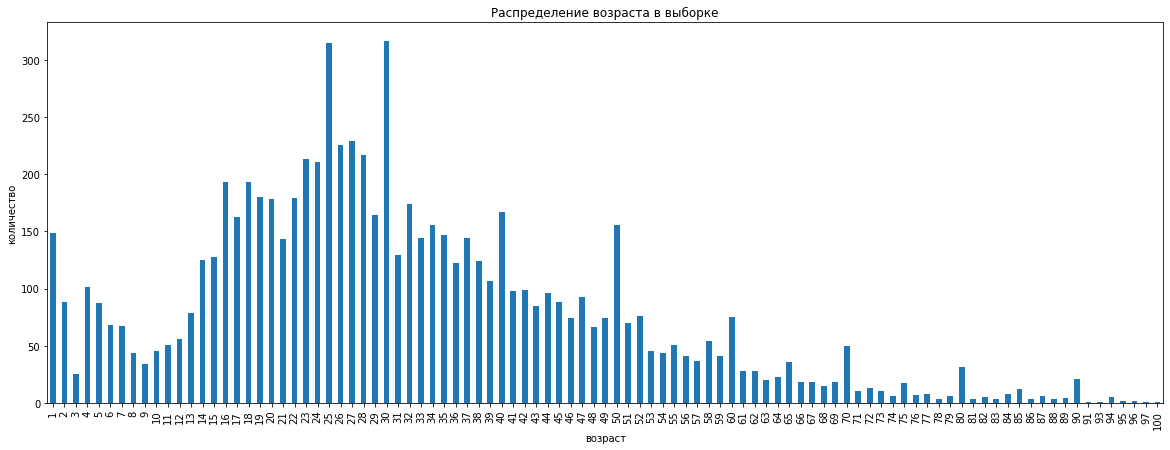

In [ ]:
(data.pivot_table(index='real_age', values='real_age', aggfunc='count')
     .plot.bar(xlabel='возраст', ylabel='количество', figsize=(20,7),
                  title='Распределение возраста в выборке',legend=None));

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
datagen_flow = datagen.flow_from_dataframe(data,
               directory='/datasets/faces/final_files/',
               x_col='file_name',
               y_col='real_age',
               target_size=(150, 150),
               batch_size=16,
               class_mode='raw',
               subset='training',
               seed=12345)

Found 7591 validated image filenames.


In [ ]:
features, target = next(datagen_flow)

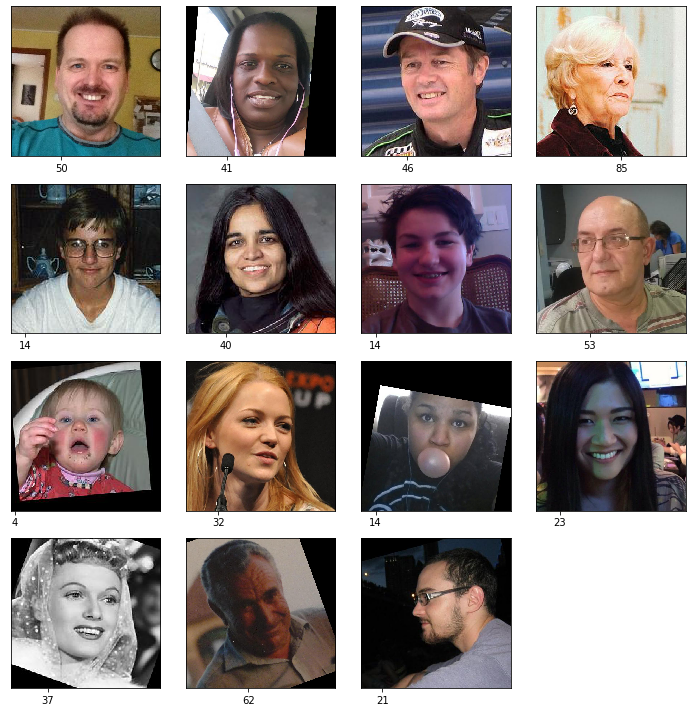

In [ ]:
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([target[i]])
    plt.yticks([])
    plt.tight_layout()

Данные содержат 7591 изображение. Возраст в выборке распределен не равномерно, основное количество фотографий людей в возрасте 16-30 лет, причем в данном возрастном периоде выделяется возрастная группа 25 и 30 лет с самым большим числом фотографий, после 30 лет количество фотографий имеет тенденцию к уменьшению, здесь можно заметить, что число фотографий людей с возрастом кратным десяти (40, 50, 60, 70, 80, 90) резко увеличивается по сравнению с соседними возрастами, что может свидетельствовать о не совсем достоверной информации о возрасте, возможно возраст просто округлялся. Если рассматривать возраст до 15 лет, то здесь мы можем наблюдать, что меньше всего фотографий 3-х летних детей, а больше всего 1-летних, скорее всего к однолетним относят и фотографии детей до года. Такое неравномерное распределение возрастов может отрицательно сказаться на качестве предсказания модели. Из напечатанных изображений датасета, мы видим, что в нем содержаться фотографии разного качества изображения, цветные и черно-белые.

## Обучение модели

```python

def load_train(path):
    data = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       rescale=1./255, horizontal_flip=True)
    train_datagen_flow = train_datagen.flow_from_dataframe(data,
        directory=path+'/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
     return train_datagen_flow
    
def load_test(path):
    data = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25,
                                      rescale=1./255)
    test_datagen_flow = test_datagen.flow_from_dataframe(data,
        directory=path+'/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow

def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=(input_shape),
                       weights='imagenet',
                       include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=4,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/4
356/356 - 52s - loss: 207.1408 - mae: 10.5057 - val_loss: 691.3723 - val_mae: 21.2926
Epoch 2/4
356/356 - 42s - loss: 89.6662 - mae: 7.2298 - val_loss: 123.1020 - val_mae: 8.3735
Epoch 3/4
356/356 - 42s - loss: 60.3982 - mae: 5.9109 - val_loss: 98.1067 - val_mae: 7.5014
Epoch 4/4
356/356 - 43s - loss: 43.9847 - mae: 5.0780 - val_loss: 83.2216 - val_mae: 7.0005
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 83.2216 - mae: 7.0005
Test MAE: 7.0005

```

## Анализ обученной модели

Для обучения модели использовалась архитектура ResNet50 (бэкбон + голова), были загружены предобученные веса ('imagenet'). Для обучения модели использовались следующие параметры: оптимизатор - Adam с learning rate = 0.0001, заморозка весов бэкбона не использовалась, т.к. данных достаточно, количество эпох – 4.
Значение функции потерь и метрики качества МАЕ улучшалось с количеством эпох. Для достижения требуемого значения МАЕ было достаточно 4 эпох. В результате обучения модели удалось добиться значения метрики МАЕ 7.0005 на тестовой выборке, что соответствует требуемому условию. Переобучение модели не наблюдалось.